In [24]:
import kagglehub
from mpmath import workdps

# Download latest version
path = kagglehub.dataset_download("dtrnngc/ua-detrac-dataset")

print("Path to dataset files:", path)


  0%|          | 0.00/9.23G [00:00<?, ?B/s]
  0%|          | 1.00M/9.23G [00:00<1:54:20, 1.44MB/s]
  0%|          | 2.00M/9.23G [00:00<56:53, 2.90MB/s]  
  0%|          | 4.00M/9.23G [00:00<26:24, 6.25MB/s]
  0%|          | 8.00M/9.23G [00:01<12:13, 13.5MB/s]
  0%|          | 12.0M/9.23G [00:01<08:29, 19.4MB/s]
  0%|          | 16.0M/9.23G [00:01<06:50, 24.1MB/s]
  0%|          | 20.0M/9.23G [00:01<06:04, 27.1MB/s]
  0%|          | 25.0M/9.23G [00:01<05:13, 31.5MB/s]
  0%|          | 29.0M/9.23G [00:01<04:53, 33.7MB/s]
  0%|          | 33.0M/9.23G [00:01<04:45, 34.6MB/s]
  0%|          | 38.0M/9.23G [00:01<04:35, 35.9MB/s]
  0%|          | 42.0M/9.23G [00:01<04:30, 36.5MB/s]
  0%|          | 46.0M/9.23G [00:02<04:26, 37.0MB/s]
  1%|          | 50.0M/9.23G [00:02<04:20, 37.9MB/s]
  1%|          | 54.0M/9.23G [00:02<04:19, 38.0MB/s]
  1%|          | 58.0M/9.23G [00:02<04:25, 37.1MB/s]
  1%|          | 63.0M/9.23G [00:02<04:34, 35.8MB/s]
  1%|          | 67.0M/9.23G [00:02<04:31, 36.3MB/

Extracting files...


Path to dataset files: /home/davevarga/.cache/kagglehub/datasets/dtrnngc/ua-detrac-dataset/versions/1


## Prerequisites

In [3]:
import os
import cv2 
import numpy as np
from torchvision import transforms
from torch.ao.nn.quantized.functional import threshold

# Reload external submodules before running a cell
import importlib

This notebook integrates the **NVIDIA CUDA Toolkit** to accelerate processes defined in the OpenCV libraries. The CUDA Toolkit provides the development environment and libraries necessary to run GPU-accelerated applications, while **PyTorch** provides a high-level interface for GPU-accelerated machine learning tasks using CUDA.

Following these steps you will be able to run Pytorch on cuda GPU:

- See if you have an NVIDIA gpu that supports *CUDA*. You can check whether your supports CUDA on the [Nvidia CUDA GPUs](https://developer.nvidia.com/cuda-gpus) list
- The *NVIDIA drivers* allow your operating system to communicate with the GPU. Download the latest driver for your GPU from [NVIDIA GPU drivers](https://www.nvidia.com/en-us/drivers/)
- The *NVIDIA CUDA® Deep Neural Network* library (cuDNN) is a GPU-accelerated library of primitives for deep neural networks. Download link: [Nvidia cuDNN](https://developer.nvidia.com/cudnn)
- The *CUDA Toolkit* provides the development environment and libraries necessary to run GPU-accelerated applications. Download the [Nvidia CUDA Toolkit](https://developer.nvidia.com/cuda-toolkit), and add CUDA binaries to your system's PATH.
- Install *PyTorch with CUDA* support by visiting the [PyTorch installation](https://pytorch.org/get-started/locally/) page and choosing the appropriate options.

After completing the above steps, verify CUDA is available by running the following in a Python 

In [4]:
import torch
import lightning

# Set up device working
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()

print("PyTorch Version:", torch.__version__)
print("Lightning Vesrion:", lightning.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("Device used:", device)

PyTorch Version: 2.4.1+cu124
Lightning Vesrion: 2.4.0
CUDA Available: True
Device used: cuda


## Dataset

The UC-Detrac dataset specializes in traffic surveillance specific images. It consists of 100 challenging video sequences captured from real-world traffic scenes (over 140,000 frames with rich annotations, including occlusion, weather, vehicle category, truncation, and vehicle bounding boxes) for object detection, object tracking and MOT system.  

It's a large dataset with more than 140, 000 frames capturing approximately 8.250 vehicles, and a total of 1.21 million bounding boxes of vehicles are labeled. To analyze the performance of object detection and tracking algorithms thoroughly, we annotate sequences with several at-tributes:

- **Vehicle type.** We annotate four types of vehicles as car, bus, van, and others
- **Illumination:** Four categories of illumination are considered showed in the figure bellow
- **Scale:** We defined the scale of the annotated vehicle bound-ing boxes as the square root of the area in pixels
- **Occlusion ratio:** We use the fraction of vehicle bound-ing box being occluded to define the occlusion ratio. We annotate the occlusion relations between vehicle bounding boxes and compute the occlusion ratio

You can download the dataset directly from Kaggle from this link: https://www.kaggle.com/api/v1/datasets/download/dtrnngc/ua-detrac-dataset?dataset_version_number=1

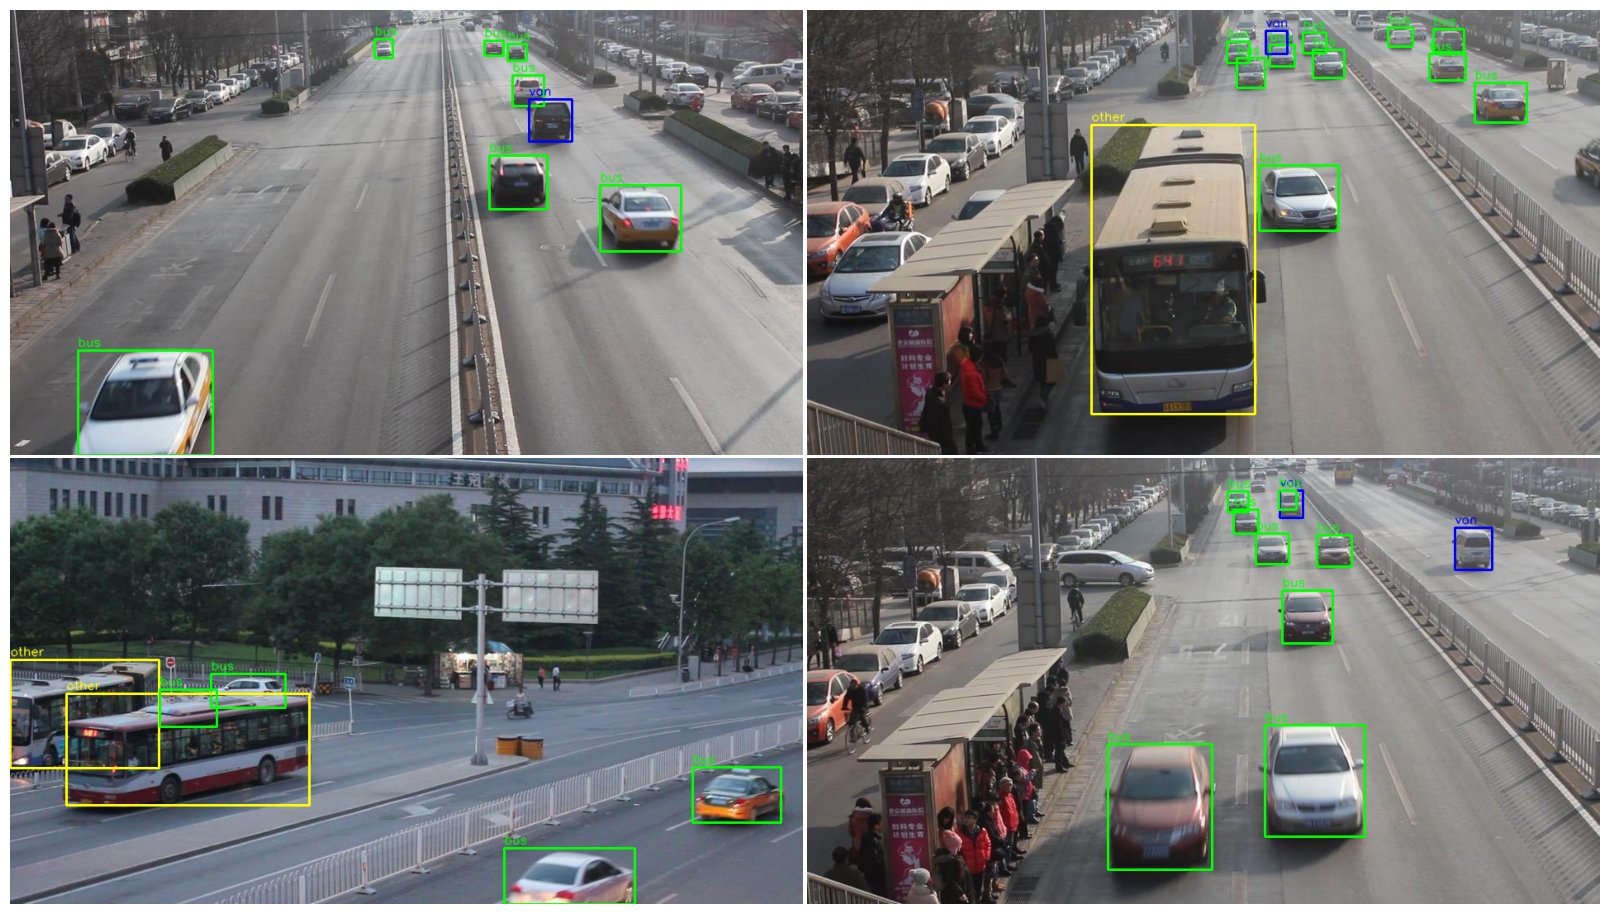

In [10]:
# Reload changes in submodule
import utils.plot
importlib.reload(utils.plot)

# Path to the image and labels dataset
images_dir = './datasets/uc-detrac/images/images'
labels_dir = './datasets/uc-detrac/labels/images'
object_names = ['car', 'bus', 'van', 'other']

# Sample 4 images from the dataset 
images_path, labels_path = utils.plot.get_random_images(images_dir, 4, labels_dir)

# Frame detection object on every image, to validate object types and correct label annotation
plot_images = []
for image_path, label_path in zip(images_path, labels_path):
    image_with_detections = utils.plot.detection(image_path, label_path, object_names)
    plot_images.append(image_with_detections)

# Visualize detection objects in UC-Detract dataset
utils.plot.grid(plot_images, layout=(2, 2), figsize=(16, 9))

# Delete unused plot information
del plot_images, images_path, labels_path

-------

To use a dataset, we can create a custom dataset class for training a YOLOv8 model, by implementing a subclass to **torch.utils.data.Dataset.** This class will handle loading images and their corresponding annotations. Below is a basic implementation of such a dataset class in PyTorch.

Using a custom dataset, we not only organize the code, but can implement logic for data augmentation and batch segmentation. In this case we want to remove labels for objects that are occluded above a threshold.

**Note:** As we can see, there are a few examples where vehicles are occluded, but labels are still present. Solving this problem requires to detect accurately vehicles, providing a paradox. Therefore, all occlusions cannot be handled, but there is a solution for cases where vehicles are occluding other vehicles.



In [17]:
# Import module every time cell is run
import DetracDataset as dd
importlib.reload(dd)

 # Define image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Define custom dataset object for UA-Detrac dataset
train_dataset = dd.DetracDataset(
    images_dir, labels_dir, img_size=640,
    transform=transform, threshold=0.85
)

DataLoaders allow you to load data in batches rather than one sample at a time. Loading data in smaller batches helps manage memory usage effectively, preventing out-of-memory errors when working with large datasets. By shuffling the data, we promote better generalization of the model, as it learns to recognize patterns without being biased by the order of samples. With parallel loading, the data can be fetched asynchronously, meaning that data preparation does not block the training process.

DataLoaders allow you to apply transformations to your data on-the-fly, such as normalization, data augmentation, or any custom preprocessing. This helps improve model robustness and performance. They help manage training across multiple epochs, making it easy to reset or modify data loading parameters as needed.

In [19]:
# Validation dataset
val_images_dir = './datasets/uc-detrac/images/val'
val_labels_dir = './datasets/uc-detrac/labels/val'

val_dataset = dd.DetracDataset(
    val_images_dir, val_labels_dir, img_size=640,
    transform=transform, threshold=0.85
)

In [23]:
from torch.utils.data import DataLoader, RandomSampler

# Only use 1% of the total dataset
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=4, sampler=RandomSampler(train_dataset, num_samples=1000))
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=4, sampler=RandomSampler(val_dataset, num_samples=1000))

## Model

The **YOLOv8** model is the latest iteration of the YOLO (*You Only Look Once*) family of object detection models, *designed for real-time detection* tasks, employing a single convolutional neural network (CNN) that *predicts bounding boxes and class probabilities simultaneously*. The model divides the input image into a grid and assigns bounding boxes and confidence scores to each grid cell, predicting multiple boxes per cell. It also *uses anchor boxes* to improve detection accuracy for different object sizes.

In [21]:
from ultralytics import YOLO

# Define own model based on YOLOv8
model = YOLO('yolov8s.pt')

# Print out informatin about the model
model.info()

YOLOv8s summary: 225 layers, 11,166,560 parameters, 0 gradients, 28.8 GFLOPs


(225, 11166560, 0, 28.816844800000002)

In [25]:
from pytorch_lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger

logger = TensorBoardLogger(save_dir=os.getcwd(), version=1, name="lightning_logs")

# Initialize Trainer with the logger
model.train_dataloader = train_loader
model.val_dataloader = val_loader

# Train the model
model.train(
    data='./datasets/uc-detrac/uc-detrac.yaml',
    epochs=5,
    batch=8,
    device=device,
    workers=8
)

New https://pypi.org/project/ultralytics/8.3.18 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=./datasets/uc-detrac/uc-detrac.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

train: Scanning /home/davevarga/PycharmProjects/bwim-cam/datasets/uc-detrac/labels/train.cache... 82085 images, 1706 backgrounds, 0 corrupt: 100%|██████████| 83791/83791 [00:00<?, ?it/s]
val: Scanning /home/davevarga/PycharmProjects/bwim-cam/datasets/uc-detrac/labels/val.cache... 56167 images, 173 backgrounds, 0 corrupt: 100%|██████████| 56340/56340 [00:00<?, ?it/s]


Plotting labels to /home/davevarga/PycharmProjects/bwim-cam/runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/davevarga/PycharmProjects/bwim-cam/runs/detect/train6
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/10474 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB. GPU 0 has a total capacity of 3.81 GiB of which 8.00 MiB is free. Including non-PyTorch memory, this process has 3.78 GiB memory in use. Of the allocated memory 3.58 GiB is allocated by PyTorch, and 76.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)